## Application: Guillotine Cuts

0 199.0
1 1059.0
2 53.0
3 0.0
4 0.0
5 0.0
6 0.0
7 53.0


,w,d,x1,x2,y1,y2,r
0,145,87,199.0,344.0,162.0,249.0,0.0
1,74,46,0.0,46.0,162.0,236.0,1.0
2,141,121,199.0,340.0,255.0,376.0,0.0
3,96,50,0.0,50.0,280.0,376.0,1.0
4,117,53,0.0,53.0,0.0,117.0,1.0
5,178,122,53.0,175.0,0.0,178.0,1.0
6,146,187,53.0,199.0,189.0,376.0,0.0
7,162,128,199.0,327.0,0.0,162.0,1.0


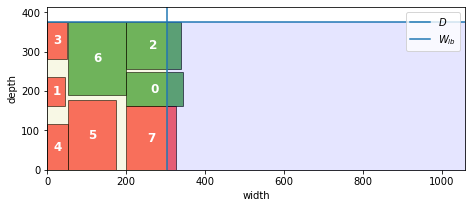

In [170]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

def pack_boxes_V3(boxes, D):
    
    W_ub = boxes["w"].sum()

    m = pyo.ConcreteModel()
    
    m.D = pyo.Param(mutable=True, initialize=D)

    m.BOXES = pyo.Set(initialize=boxes.index)
    m.GCUTS = pyo.Set(initialize=boxes.index)
    m.PAIRS = pyo.Set(initialize=m.BOXES * m.BOXES, filter=lambda m, i, j: i < j)

    m.W = pyo.Var(domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.x1 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.x2 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.y1 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.y2 = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))
    m.r = pyo.Var(m.BOXES, domain=pyo.Binary)
    
    m.gcut = pyo.Var(m.BOXES, domain=pyo.NonNegativeReals, bounds=(0, W_ub))

    @m.Objective()
    def minimize_width(m):
        return m.W
    
    @m.Constraint(m.BOXES)
    def width(m, i):
        return m.x2[i] <= m.W
    
    @m.Constraint(m.BOXES)
    def height(m, i):
        return m.y2[i] <= m.D
    
    @m.Disjunction(m.BOXES)
    def rotate(m, i):
        return [[m.r[i] == 0, 
                 m.x2[i] == m.x1[i] + boxes.loc[i, "w"],
                 m.y2[i] == m.y1[i] + boxes.loc[i, "d"]],
                
                [m.r[i] == 1, 
                 m.x2[i] == m.x1[i] + boxes.loc[i, "d"],
                 m.y2[i] == m.y1[i] + boxes.loc[i, "w"]]
               ]

    @m.Disjunction(m.PAIRS)
    def no_overlap(m, i, j):
        return [m.x2[i] <= m.x1[j],
                m.x2[j] <= m.x1[i],
                m.y2[i] <= m.y1[j],
                m.y2[j] <= m.y1[i]]
    
    @m.Disjunction(m.BOXES)
    def guillotine(m, i):
        return [ [m.x1[i] == m.gcut[k]] for k in m.GCUTS]
    
    @m.Disjunction(m.BOXES, m.GCUTS)
    def lr(m, i, k):
        return [ m.x2[i] <= m.gcut[k], m.x1[i] >= m.gcut[k] ]


    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    solver = pyo.SolverFactory("gurobi_direct")
    solver.solve(m)

    soln = boxes.copy()
    soln["x1"] = [m.x1[i]() for i in boxes.index]
    soln["x2"] = [m.x2[i]() for i in boxes.index]
    soln["y1"] = [m.y1[i]() for i in boxes.index]
    soln["y2"] = [m.y2[i]() for i in boxes.index]
    soln["r"] = [m.r[i]() for i in boxes.index]
    
    for k in m.GCUTS:
        print(k, m.gcut[k]())
    return soln

soln = pack_boxes_V3(boxes, D)
display(soln)
show_boxes(soln, D)